In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import datetime as dt
import random as ran
from sklearn.metrics.pairwise import euclidean_distances as euc

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from src.dbc import TimeDivisionKMeans
from src.dbc.utils import data_preprocessing, dimension_reduction, calc_contribution

In [19]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
df = data_preprocessing(xlsx)

# 3. dimension_reduction
df = dimension_reduction(df)

# 4. day clustering
copy_df = df.copy()

In [23]:
# 4. day clustering
df = copy_df[:96]

df.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2018-05-01 00:00:00,0.341,0.121,0.245,0.009,0.085,0.154,0.161,0.311,0.358,0.177,...,0.372,0.181,0.322,0.374,0.571,0.453,0.161,0.127,0.259,0.364
2018-05-01 01:00:00,0.337,0.186,0.285,0.010,0.071,0.127,0.179,0.225,0.206,0.178,...,0.245,0.238,0.292,0.382,0.327,0.352,0.172,0.133,0.234,0.286
2018-05-01 02:00:00,0.324,0.214,0.487,0.009,0.061,0.139,0.182,0.221,0.150,0.152,...,0.245,0.250,0.287,0.320,0.359,0.366,0.242,0.219,0.197,0.368
2018-05-01 03:00:00,0.319,0.250,0.300,0.009,0.067,0.132,0.172,0.274,0.142,0.205,...,0.177,0.223,0.329,0.170,0.322,0.267,0.269,0.164,0.229,0.414
2018-05-01 04:00:00,0.235,0.199,0.107,0.009,0.047,0.131,0.153,0.255,0.139,0.169,...,0.129,0.171,0.301,0.168,0.351,0.255,0.170,0.132,0.198,0.318


In [24]:
# 일반 euclidean distance KMeans 방식
size=96
tdKMeans = TimeDivisionKMeans(df, size=96)
hc, ci = tdKMeans.run()

_hc = hc.copy()
_test = list()

for col in _hc:
    _hc_info = _hc[col].copy()
    contributions = [ci[division_round][1][int(_)] for division_round,_ in enumerate(_hc_info)]
    _test.append(contributions.copy())

contribution_df = pd.DataFrame(_test).T
contribution_df.columns = df.columns

contribution_df

# 실제(합산치 상에서의) 최소, 최대 사용량 가구
cols = df.columns

sum_df = (df.sum() * 1000).round() / 1000
min_h = cols[sum_df.argmin()]
max_h = cols[sum_df.argmax()]
print("실제 (합산치 상에서의) 최소, 최대 사용량 가구")
print("- 최소: {} ({}kwh) / 최대: {} ({}kwh)\n".format(
    min_h,
    sum_df[min_h],
    max_h,
    sum_df[max_h]
))

mean_cont_df = contribution_df.mean().round().astype("int")
_min_h = cols[mean_cont_df.argmin()]
_max_h = cols[mean_cont_df.argmax()]
print("기여도 최소, 최대 사용량 가구")
print("- 최소: {} ({}kwh) (기여도: {}%) / 최대: {} ({}kwh) (기여도: {}%)\n".format(
    _min_h,
    sum_df[min_h],
    mean_cont_df[_min_h],
    _max_h,
    sum_df[max_h],
    mean_cont_df[_max_h]
))
print("발견 #1. 클러스터링 방식의 기여도 분배는 다른 분배 방식들과 다르게 최대사용량 가구의 부담을 덜어줄 수 있었다.")
print("- 최소사용량 가구 기여도 , 최대사용량 가구 기여도 비교 {}배".format(round(mean_cont_df[_max_h] / mean_cont_df[_min_h])))

실제 (합산치 상에서의) 최소, 최대 사용량 가구
- 최소: 아파트1-104-1208 (0.873kwh) / 최대: 아파트1-103-703 (64.485kwh)

기여도 최소, 최대 사용량 가구
- 최소: 아파트1-104-303 (0.873kwh) (기여도: 5%) / 최대: 아파트1-103-1502 (64.485kwh) (기여도: 25%)

발견 #1. 클러스터링 방식의 기여도 분배는 다른 분배 방식들과 다르게 최대사용량 가구의 부담을 덜어줄 수 있었다.
- 최소사용량 가구 기여도 , 최대사용량 가구 기여도 비교 5배


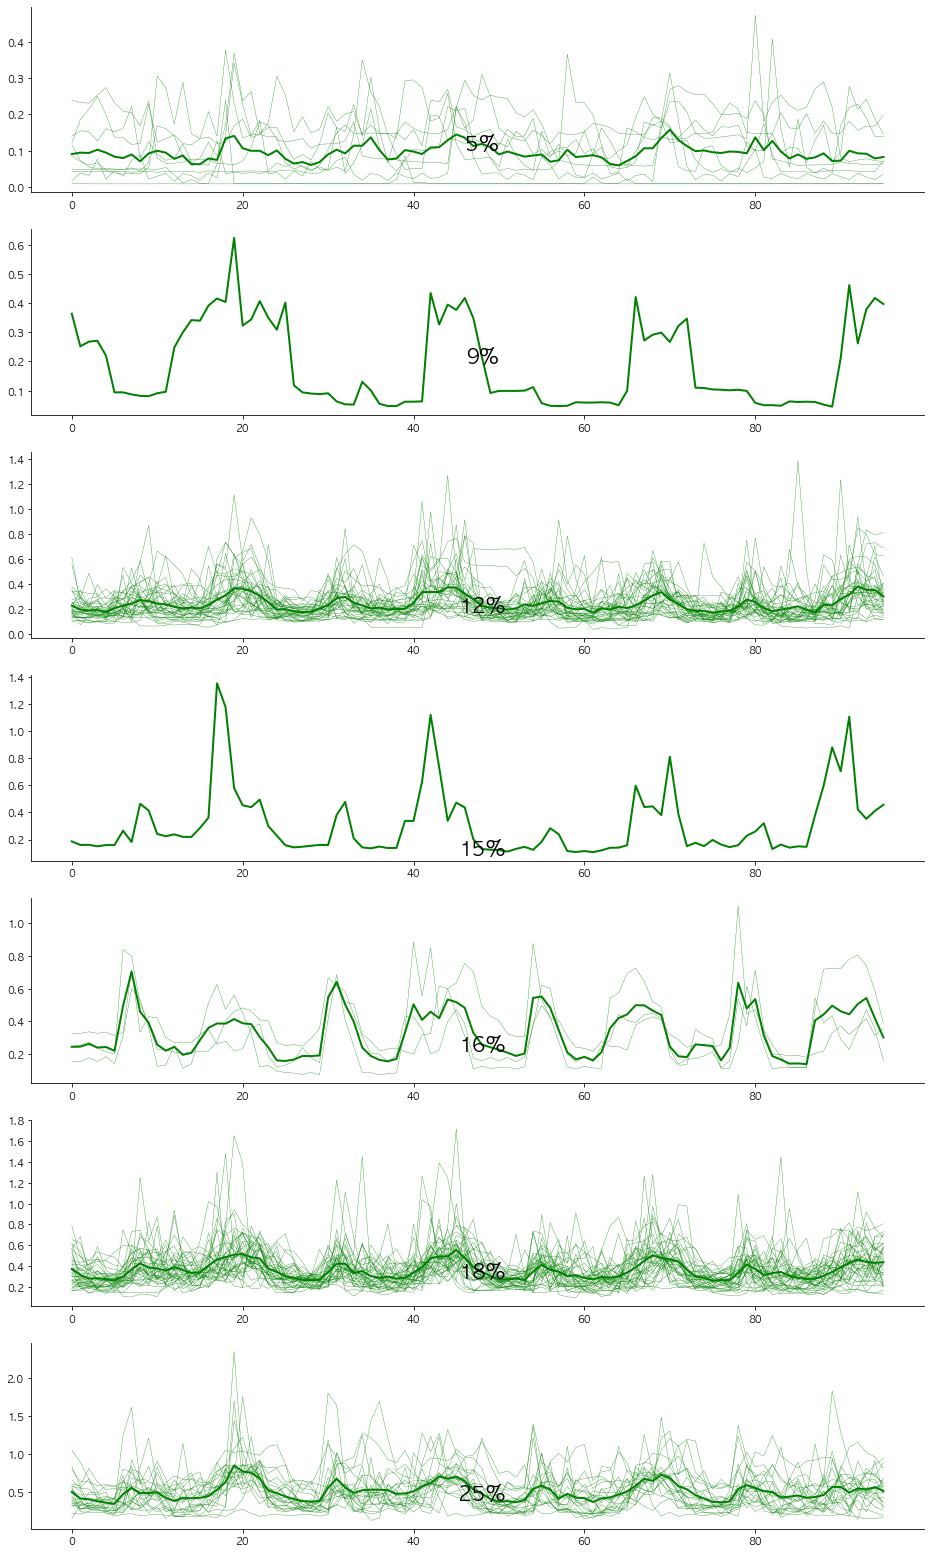

In [25]:
# 전체
_sort_ci = list()
cluster_pattern = np.array([])
fig,ax = plt.subplots(len(ci[0][0]), len(ci), figsize=(16,4 * len(ci[0][0])))
fig.subplots_adjust(wspace=0.01)

for rank in range(0, len(ci[0][0])):
    for ci_idx, _ci in enumerate(ci):
        _min_idx = _ci[1].argsort()[rank]
        _contribution = _ci[1][_min_idx]
        _cluster_pattern = _ci[0][_min_idx]

        household_ci = hc.iloc[ci_idx].values
        _in_cluster = np.where(household_ci == _min_idx)
        in_cluster = df.columns[_in_cluster]

        households_patterns = df[in_cluster].T.values
        x = [_ for _ in range(0,size)]
        for hp in households_patterns:
            ax[rank].plot(range(0, size), hp, color="g", linewidth=0.3)
        
        ax[rank].plot(range(0,size),_cluster_pattern, color="g", linewidth=2)

        ax[rank].spines['right'].set_visible(False)
        ax[rank].spines['top'].set_visible(False)
        
        ax[rank].text(x[round(size / 2)],_cluster_pattern[round(size / 2)], 
                              "{}%".format(int(_contribution)) ,
                             fontsize=20,
                             verticalalignment ='center', 
                             horizontalalignment ='center')

        if ci_idx > 0:
            ax[rank][ci_idx].spines['left'].set_visible(False)
            ax[rank][ci_idx].yaxis.set_ticks([])
            ax[rank][ci_idx].yaxis.set_ticklabels([])